# *Exploratory data analysis of dataset*

## Piotr Szyszka
### ***Lublin University of Technology***
### *Engineering and Data Analysis, 2024*
### *Advanced Machine Learning Methods*



This notebook aims to delve into the structure of data dedicated for the project. Exploratory data analysis should ALWAYS be the first step in model building work. It enables us to understand the nature of the data, catch any outliers, and thus develop an effective strategy for the project.

Since we're dealing with string data, the analysis will be tailored specifically to this type of data. We will focus on various aspects, including missing data imputations,examining word lengths, etc.

In [35]:
# Data manipulation
from datasets import load_dataset, concatenate_datasets, Dataset
import pandas as pd
import numpy as np 

# Visualizations
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data sources

Found data sources used in this project:

- `Amod/mental_health_counseling_conversations` - specific data for mental health

- `allenai/prosocial-dialog` - casual dialogs, helpful for model to immitate human behaviour and to not overfit to task



In [2]:
def get_casual_data(num_observations: int) -> Dataset:
    data = load_dataset('allenai/prosocial-dialog')
    data = concatenate_datasets([data['train'], data['validation'], data['test']])

    df = pd.DataFrame(data)


    filtered_df = df[df['safety_label'] == '__casual__']

    fdf = filtered_df[['context', 'response']].rename(columns= {'context': 'Context', 'response': 'Response'})

    fdf = fdf.sample(num_observations, random_state=100)
    
    return Dataset.from_pandas(fdf).select_columns(['Context', 'Response'])
    

In [3]:
casual_data = get_casual_data(num_observations=2_000) # get only 2k of casual data 

In [4]:
casual_data[range(10)]

{'Context': ['I rather say that I love myself than someone else',
  "Because it's the only way to learn how to get better.",
  'I want to spend less time shopping, and I find the prices online more affordable',
  "Yes we were supposed to be together...He's my rebound XD",
  "I don't want to talk in the morning",
  "I'm going to tell to one of my closest friends that she is in an abusive relationship.",
  'I thinking of quitting my job to maybe become a freelance worker.',
  "Yes, I don't eat pork and my mom frequently does that without asking, just thinking she knows what I want to eat",
  "I'm going to dress in an indian dress for my creative grad shoot",
  'What do I do about finding my stepmother extremely attractive? I need help!'],
 'Response': ['It is good to have self confidence, but it is not normal to look down on someone for loving you.   You should be receptive  to the love of others or you may find yourself alone.',
  'That sounds like a positive way to approach things. It 

In [5]:
mentalhealth = load_dataset('Amod/mental_health_counseling_conversations')
mentalhealth

DatasetDict({
    train: Dataset({
        features: ['Context', 'Response'],
        num_rows: 3512
    })
})

In [6]:
mentalhealth = mentalhealth['train']

This dataset consists of only one set with 2 features. 

Number of observation is 3512 and that is not so many. In our case, when the project goal is to build and train transformer from scratch, it makes it very difficult with only this amount of data.

In [7]:
dataset = concatenate_datasets([mentalhealth, casual_data]).shuffle(seed = 2024) # concatenate both datasets

In [8]:
dataset

Dataset({
    features: ['Context', 'Response'],
    num_rows: 5512
})

In [9]:
dataset[1212]

{'Context': 'What do I do about finding my stepmother extremely attractive? I need help!',
 'Response': 'Well, first you could tell me what you find so attractive about her?'}

# NA instances

In [10]:
dataset.to_pandas().isna().sum()

Context     0
Response    0
dtype: int64

There are no misisng observations in the dataset.

# Sentences lenghts

In [11]:
context_lens = [len(x['Context'].split()) for x in dataset]
response_lens = [len(x['Response'].split()) for x in dataset]

In [12]:
sentences_lens = pd.DataFrame({'context_lens': context_lens, 'response_lens': response_lens})

In [13]:
sentences_lens

,context_lens,response_lens
0,86,151
1,8,138
2,17,239
3,9,21
4,40,89
...,...,...
5507,21,77
5508,47,85
5509,12,13
5510,113,316


In [14]:
sentences_lens.describe()

,context_lens,response_lens
count,5512.000000,5512.000000
mean,39.700109,120.812228
std,43.802234,122.080329
min,1.000000,0.000000
25%,13.000000,27.000000
50%,26.000000,87.000000
75%,55.000000,175.000000
max,526.000000,939.000000


In [15]:
no_response_idx = sentences_lens.loc[sentences_lens['response_lens'] < 2, :].index


sentences_lens.iloc[no_response_idx, :]

,context_lens,response_lens
27,57,0
250,5,1
1960,16,0
2323,88,0
2672,30,1
2938,9,0
4798,30,1
5353,30,1


In [16]:
dataset[no_response_idx]

{'Context': ["I’m trying to make marriage work after a split. Before our split, he lied a lot and broke every promise to me. I don't think he cheated. Last month, I asked what women work with him, so he told me. Yesterday, I found out about a girl that he said he forgot about. Should I be upset?",
  ' such as not enough sleep',
  'Every winter I find myself getting sad because of the weather.  How can I fight this?',
  'From the moment I wake up, I hear what I think is my voice in my head. Even now, I hear it saying every word I’m thinking. When I lay down to sleep, I think of weird and crazy things, and the voice will never stop talking. I don’t know if it’s me thinking. It never stops. I’ll lay in my bed for hours just thinking about weird stuff. I should mention that I talk to myself a lot: mostly in my head, but out loud as well.',
  "I've gone to a couple therapy sessions so far and still everytime I walk in I get nervous and shaky. Is this normal? Should I still be feeling like t

In [17]:
dataset = dataset.select(i for i in range(len(dataset)) 
                if i not in set(no_response_idx))

Parameter 'indices'=<generator object <genexpr> at 0x7499cb3f7370> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [18]:
dataset

Dataset({
    features: ['Context', 'Response'],
    num_rows: 5504
})

In [19]:
# recalculate statistics
context_lens = [len(x['Context'].split()) for x in dataset]
response_lens = [len(x['Response'].split()) for x in dataset]


sentences_lens = pd.DataFrame({'context_lens': context_lens, 'response_lens': response_lens})

sentences_lens.describe()

,context_lens,response_lens
count,5504.000000,5504.000000
mean,39.709666,120.987100
std,43.822404,122.082754
min,1.000000,2.000000
25%,13.000000,27.000000
50%,26.000000,87.000000
75%,55.000000,175.000000
max,526.000000,939.000000


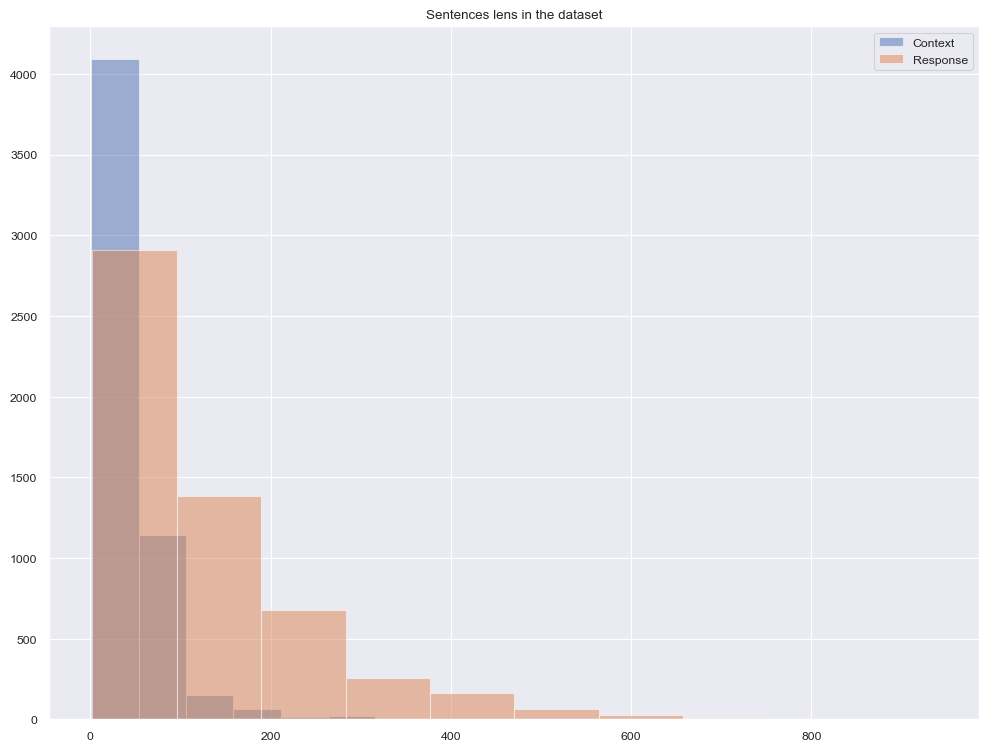

In [20]:
sns.set('paper')

plt.figure(figsize=(12, 9))

plt.hist(sentences_lens['context_lens'], label = 'Context', alpha = 0.5)
plt.hist(sentences_lens['response_lens'], label = 'Response', alpha = 0.5)

plt.title('Sentences lens in the dataset')

plt.legend()

As we can see above, responses are rather longer than `Context` (input) sentences. There also are noticable very long sentences in both of features. Let's take a look at them.

In [21]:
long_context_ids = sentences_lens[sentences_lens['context_lens'] > 150].index
print('Long context instnaces:', len(long_context_ids))
dataset[long_context_ids]

Long context instnaces: 137


{'Context': ["I was having a sexual relationship with a coworker. He decided he was going to get a hotel room for the weekend. Before I got paid, I told him I would have $25.00, which I thought I would. But when I saw my paycheck, I could not pay the $25.00. He says I lied to him about it. He wants me to reimburse him $25.00 for the hotel room he decided to get. He stayed at the hotel, and I left. I don't think it's right that he want me to reimburse him $25.00 for a hotel room he wanted to get in the first place. He is out of town right now and texted me yesterday telling me I am a liar and that I should never said I was going to have $25.00 when I knew I wasn't. I told him I had to pay rent and my rent was late. He texted me saying I need to get two or three jobs.",
  "Hello, I have a cousin in my family who has been making me feel belittled, insecure, and frustrated during her stay here in the city. I know she comes from a place of love, but she has always been short-fused and highl

In [22]:
long_response_ids = sentences_lens[sentences_lens['response_lens'] > 450].index
print('Long context instnaces:', len(long_context_ids))
# dataset[long_context_ids]

Long context instnaces: 137


There are not so many instances like that so we can't treat them like some kind of outliers. They are explicitly long compared to others and it may cause issues. Keeping that long sentences in dataset will later require pad every sentence to longest one or truncate. Because of there are not so many instances of that kind, let's decide to delete them from the dataset.

In [23]:
exclude_idxs = set(list(long_context_ids) + list(long_response_ids))

dataset = dataset.select(i for i in range(len(dataset)) 
                if i not in set(exclude_idxs))

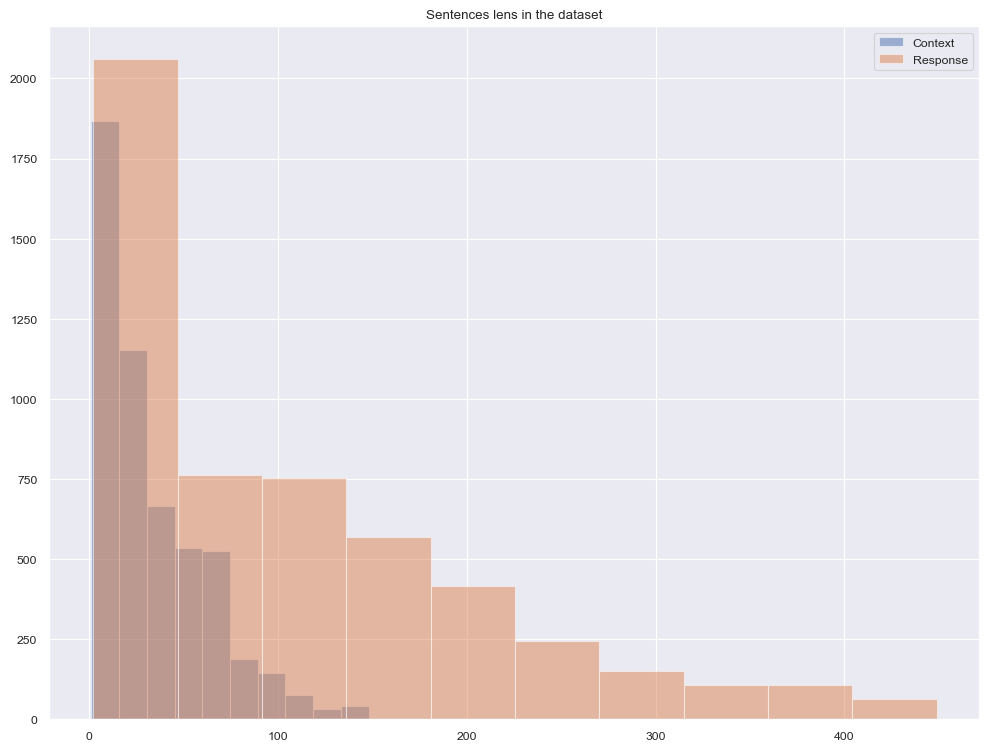

In [24]:
# recalculate statistics
context_lens = [len(x['Context'].split()) for x in dataset]
response_lens = [len(x['Response'].split()) for x in dataset]


sentences_lens = pd.DataFrame({'context_lens': context_lens, 'response_lens': response_lens})

sentences_lens.describe()


plt.figure(figsize=(12, 9))

plt.hist(sentences_lens['context_lens'], label = 'Context', alpha = 0.5)
plt.hist(sentences_lens['response_lens'], label = 'Response', alpha = 0.5)

plt.title('Sentences lens in the dataset')

plt.legend()

Now histograms look okay.

# Wordcloud

A word cloud is a visualization technique used in Natural Language Processing (NLP) to represent text data. It displays the most frequently occurring words in a corpus, where the size of each word is proportional to its frequency of occurrence.

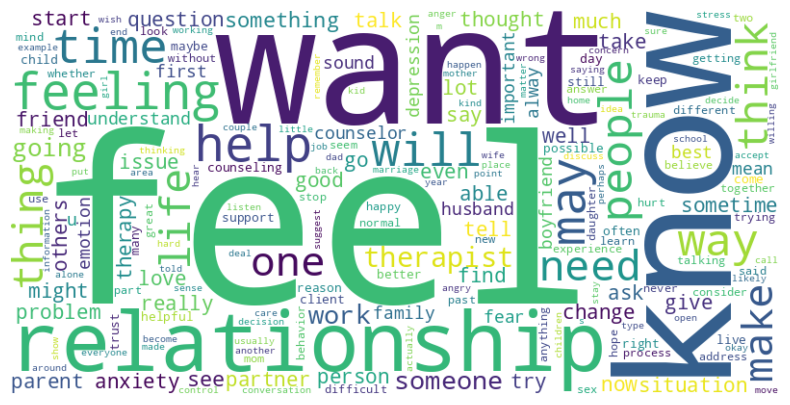

In [25]:
combined_text = ' '.join(dataset['Context']) + ' ' + ' '.join(dataset['Response'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

As we can see on the figure above, most of the words in Wordcloud are related to emotions. We can also notice that the largest  words are related to subjective feelings. This all indicates that the text is likely discussing or expressing feelings, opinions, or personal experiences rather than presenting factual information (what is consistent to the nature of source of this dataset).

# Text data normalization

Normalization of text might be very useful to train models. It reduces noise and when number of training data is limited, it may also improve overall performance. But abandoning these benefits, the decision was made to not to normalize the dataset! The reason for this is a need to preserve the authenticity and diversity of the dataset. By maintaining the original text without normalization, the model can better capture the nuances and variations present in real-world data. This decision was driven by the desire to ensure that the trained model reflects the natural language patterns and idiosyncrasies encountered in the target domain or application. While normalization can offer advantages in certain contexts, in this case, prioritizing raw data integrity was deemed more valuable for the intended purpose.

# Split and save locally dataset

We're dividing the collected data into two distinct subsets: training and testing, with a ratio of 95% for training and 5% for testing. While this split ratio might seem unconventional, in this particular task, the final evaluation of the model will be conducted manually rather than relying solely on metrics. Given our limited number of training samples, each one is invaluable. Moreover, with over 250 samples, the dataset's size is reasonably robust.


Training dataset will be later splitted into validation to ensure that overfitting is not present.

In [57]:
train_size = 0.95

train_ds_size = int(train_size * len(dataset))
test_ds_size = len(dataset) - train_ds_size

print('Number of training instances:', train_ds_size)
print('Number of test instances:', test_ds_size)
np.random.seed(2024)
indices = np.random.permutation(len(dataset))


train_indices = indices[:train_ds_size]
test_indices = indices[train_ds_size:]


train_dataset = dataset.select(train_indices)
test_dataset = dataset.select(test_indices)


train_dataset.to_parquet('./MH_train.parquet')
test_dataset.to_parquet('./MH_test.parquet')


Number of training instances: 4973
Number of test instances: 262


Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 192.74ba/s]


249736

# References

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/


<!-- # @misc{bertagnolli2020counsel,
#   title={Counsel chat: Bootstrapping high-quality therapy data},
#   author={Bertagnolli, Nicolas},
#   year={2020},
#   publisher={Towards Data Science. https://towardsdatascience. com/counsel-chat~…}
# }
 -->

